In [3]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import math

### A linear Poisson equation
$\nabla^2 u = sin(\pi x) sin(\pi y)$ \
$0 \leq x \leq 1$ \
$0 \leq y \leq 1$

### Problem specific functions / variables

In [4]:
# partial differential equation
def f(x):
    return torch.sin(torch.tensor(math.pi)*x[:,0]) * torch.sin(torch.tensor(math.pi)*x[:,1])

def L(model, x):
    y = model(x.float())
    y_x = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
    retain_graph=True,
    create_graph=True,
    allow_unused=True)[0]

    y_xx = torch.autograd.grad(y_x, x, grad_outputs=torch.ones_like(y_x),
    retain_graph=True,
    create_graph=True,
    allow_unused=True)[0]

    return torch.sum(y_xx, -1)

# boundary conditions
def g(x):
    return 0

def B(model, x):
    return model(x.float())

# Quadrature

xs = torch.linspace(0, 1, steps=10)
ys = torch.linspace(0, 1, steps=10)
x,y = torch.meshgrid(xs, ys)
w = torch.cat((torch.reshape(x, (1,-1)), torch.reshape(y,(1,-1))), 0).T

dw = []
for xy in w:
    if xy[0] == 0 or xy[1] == 0 or xy[0] == 1 or xy[1] == 1:
        dw.append(xy)
dw = torch.stack(dw)

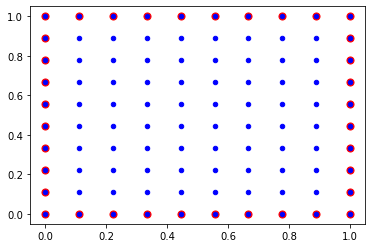

In [5]:
plt.scatter(dw[:,0],dw[:,1], c = 'r', s = 50)
plt.scatter(w[:,0],w[:,1], c = 'b', s = 20)
plt.show()
# add proper pyplot defualts

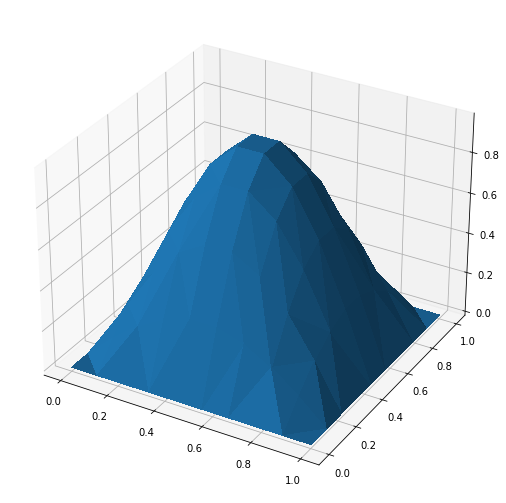

In [17]:
# Creating dataset
z = f(w)
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
surf = ax.plot_trisurf(w[:,0],w[:,1], z, linewidth=0, antialiased=False)
plt.show()

### Loss function

In [ ]:
def h(model, x):
    loss = torch.sum(torch.square(L(model, x) - f(model, x)) + torch.square(B(model, x) - g(model, x)))
    return loss

### Training loop

In [ ]:
#define the loss fn and optimizer
criterion = h()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#initialize empty list to track batch losses
# batch_losses = []

#train the neural network for 5 epochs
for epoch in range(5):

    #reset iterator
    dataiter = iter(dataloader)
    
    for batch in dataiter:
                
        #reset gradients
        optimizer.zero_grad()
        
        #forward propagation through the network
        out = model(batch["..."])
        
        #calculate the loss
        loss = criterion(out, batch["..."])
        
        #track batch loss
        batch_losses.append(loss.item())
        
        #backpropagation
        loss.backward()
        
        #update the parameters
        optimizer.step()